In [20]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [21]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from scikitplot.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

In [22]:
data = pd.read_csv("dataset_7days.csv")
data.head(2)

,Date,Open,High,Low,Close,Volume,Adjusted_Close,vix_Open,vix_High,vix_Low,...,MACD_Signal,MACD_Hist,%K,%D,ROC,OBV,Williams %R,Price_7_days,Close_Price_Change,Price_7_days_Status
0,2/22/10,200.947759,202.379443,199.021739,200.779420,16897487.81,6.102386,22.183421,22.769144,21.149518,...,1.541386,-4.823800,64.867188,52.157014,2.040661,-206307243.7,-20.636615,205.913700,5.134281,1
1,2/23/10,200.710809,202.117071,198.193769,199.849275,17807929.44,6.074116,21.735047,22.561849,20.877127,...,1.433913,-4.465322,71.912721,62.765477,1.910569,-224115173.1,-28.980129,207.112782,7.263507,1


In [23]:
def OSR2(model, df_train, df_test, dependent_var):   
    y_test = df_test[dependent_var]
    y_pred = model.predict(df_test)
    SSE = np.sum((y_test - y_pred)**2)
    SST = np.sum((y_test - np.mean(df_train[dependent_var]))**2)    
    return 1 - SSE/SST

def VIF(df, columns):
    values = sm.add_constant(df[columns]).values
    num_columns = len(columns)+1 # add intercept
    vif = [variance_inflation_factor(values, i) for i in range(num_columns)]
    return pd.Series(vif[1:], index=columns)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(data, data[["Price_7_days_Status"]], test_size=0.2, random_state=42)


In [25]:
X_train.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted_Close',
       'vix_Open', 'vix_High', 'vix_Low', 'vix_Close', 'vix_Adj_Close',
       'vix_Volume', 'nasdaq_Open', 'nasdaq_High', 'nasdaq_Low',
       'nasdaq_Close', 'nasdaq_Adj_Close', 'nasdaq_Volume', 'RSI', 'MACD',
       'MACD_Signal', 'MACD_Hist', '%K', '%D', 'ROC', 'OBV', 'Williams %R',
       'Price_7_days', 'Close_Price_Change', 'Price_7_days_Status'],
      dtype='object')

In [26]:
cols = ["Open", "High", "Low", "Close", "Volume", "Adjusted_Close", "vix_Open", \
        "vix_High", "vix_Low", "vix_Close", "vix_Adj_Close", "nasdaq_Open", "nasdaq_High", \
        "nasdaq_Low", "nasdaq_Close", "nasdaq_Adj_Close", "RSI", "MACD", "MACD_Signal", \
        "MACD_Hist"]
        
logreg = smf.logit(formula = 'Price_7_days_Status ~ Open + High + Low + Close + Volume + Adjusted_Close + vix_Open + \
                              vix_High + vix_Low + vix_Close + vix_Adj_Close + nasdaq_Open + nasdaq_High + \
                              nasdaq_Low + nasdaq_Close + nasdaq_Adj_Close + RSI + MACD + MACD_Signal+ \
                              MACD_Hist', data = X_train).fit()

print(logreg.summary())

print()
print("OSR2 for this model is:", OSR2(logreg, X_train, X_test, 'Price_7_days_Status'))
print()
VIF(X_train, cols)

         Current function value: 0.595648
         Iterations: 35
                            Logit Regression Results                           
Dep. Variable:     Price_7_days_Status   No. Observations:                 1779
Model:                           Logit   Df Residuals:                     1758
Method:                            MLE   Df Model:                           20
Date:                 Sat, 06 May 2023   Pseudo R-squ.:                  0.1214
Time:                         05:09:18   Log-Likelihood:                -1059.7
converged:                       False   LL-Null:                       -1206.1
Covariance Type:             nonrobust   LLR p-value:                 2.211e-50
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.1818      0.809      1.461      0.144      -0.403       2.767
Open                -0.2284      0.043 

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Open                6.166547e+04
High                8.254660e+04
Low                 6.748800e+04
Close               1.014033e+05
Volume              3.836890e+00
Adjusted_Close      3.368994e+01
vix_Open            6.806294e+02
vix_High            7.992310e+02
vix_Low             7.023050e+02
vix_Close                    inf
vix_Adj_Close                inf
nasdaq_Open         1.342796e+05
nasdaq_High         1.766683e+05
nasdaq_Low          1.515910e+05
nasdaq_Close                 inf
nasdaq_Adj_Close             inf
RSI                 4.094781e+00
MACD                         inf
MACD_Signal                  inf
MACD_Hist                    inf
dtype: float64

In [27]:
# remove vix_Adj_Close, vix_Close, MACD, MACD_Signal, MACD_Hist 

cols = ["Open", "High", "Low", "Close", "Adjusted_Close", "vix_Open", \
        "vix_High", "vix_Low", "nasdaq_Open", "nasdaq_High", \
        "nasdaq_Low", "nasdaq_Close", "RSI"]
        
logreg = smf.logit(formula = 'Price_7_days_Status ~ Open + High + Low + Close + Adjusted_Close + vix_Open + \
                              vix_High + vix_Low + nasdaq_Open + nasdaq_High + \
                              nasdaq_Low + nasdaq_Close + RSI', data = X_train).fit()

print(logreg.summary())

print()
print("OSR2 for this model is:", OSR2(logreg, X_train, X_test, 'Price_7_days_Status'))
print()
VIF(X_train, cols)

Optimization terminated successfully.
         Current function value: 0.598258
         Iterations 6
                            Logit Regression Results                           
Dep. Variable:     Price_7_days_Status   No. Observations:                 1779
Model:                           Logit   Df Residuals:                     1765
Method:                            MLE   Df Model:                           13
Date:                 Sat, 06 May 2023   Pseudo R-squ.:                  0.1176
Time:                         05:09:18   Log-Likelihood:                -1064.3
converged:                        True   LL-Null:                       -1206.1
Covariance Type:             nonrobust   LLR p-value:                 6.225e-53
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2599      0.676      0.384      0.701      -1.065       1.585
Open     

Open               59655.044603
High               78438.302407
Low                65635.211334
Close              96821.020608
Adjusted_Close        16.275496
vix_Open             585.169084
vix_High             158.428384
vix_Low              327.185621
nasdaq_Open       122386.250447
nasdaq_High       150398.888039
nasdaq_Low        112894.958969
nasdaq_Close      151382.263548
RSI                    1.543131
dtype: float64

In [28]:
# remove nasdaq_High, Close, nasdaq_Low, Open, nasdaq_Close

cols = ["High", "Low", "Adjusted_Close", "vix_Open", \
        "vix_High", "vix_Low", "nasdaq_Open", "RSI"]
        
logreg = smf.logit(formula = 'Price_7_days_Status ~ High + Low + Adjusted_Close + vix_Open + \
                              vix_High + vix_Low + nasdaq_Open + \
                              RSI', data = X_train).fit()

print(logreg.summary())

print()
print("OSR2 for this model is:", OSR2(logreg, X_train, X_test, 'Price_7_days_Status'))
print()
VIF(X_train, cols)

Optimization terminated successfully.
         Current function value: 0.627815
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:     Price_7_days_Status   No. Observations:                 1779
Model:                           Logit   Df Residuals:                     1770
Method:                            MLE   Df Model:                            8
Date:                 Sat, 06 May 2023   Pseudo R-squ.:                 0.07400
Time:                         05:09:19   Log-Likelihood:                -1116.9
converged:                        True   LL-Null:                       -1206.1
Covariance Type:             nonrobust   LLR p-value:                 2.118e-34
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.6526      0.573     -1.139      0.255      -1.775       0.470
High     

High              8459.504443
Low               8703.580464
Adjusted_Close      15.401451
vix_Open           439.567280
vix_High           128.881188
vix_Low            253.722624
nasdaq_Open         25.517463
RSI                  1.364188
dtype: float64

In [29]:
# remove nasdaq_Open, nasdaq_High, nasdaq_Close 

cols = ["Open", "High", "Low", "Close", "Adjusted_Close", "vix_Open", \
        "vix_High", "vix_Low", "nasdaq_Low", "RSI"]
        
logreg = smf.logit(formula = 'Price_7_days_Status ~ Open + High + Low + Close + Adjusted_Close + vix_Open + \
                              vix_High + vix_Low + nasdaq_Low + RSI', data = X_train).fit()

print(logreg.summary())

print()
print("OSR2 for this model is:", OSR2(logreg, X_train, X_test, 'Price_7_days_Status'))
print()
VIF(X_train, cols)

Optimization terminated successfully.
         Current function value: 0.598738
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:     Price_7_days_Status   No. Observations:                 1779
Model:                           Logit   Df Residuals:                     1768
Method:                            MLE   Df Model:                           10
Date:                 Sat, 06 May 2023   Pseudo R-squ.:                  0.1169
Time:                         05:09:19   Log-Likelihood:                -1065.2
converged:                        True   LL-Null:                       -1206.1
Covariance Type:             nonrobust   LLR p-value:                 1.002e-54
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2016      0.608      0.331      0.740      -0.991       1.394
Open     

Open              44001.544598
High              47083.816126
Low               39688.611671
Close             50961.871337
Adjusted_Close       15.653953
vix_Open            475.740434
vix_High            131.628790
vix_Low             271.589998
nasdaq_Low           26.795092
RSI                   1.532348
dtype: float64

In [30]:
# remove Adjusted_Close, Close

cols = ["Open", "High", "Low", "vix_Open", \
        "vix_High", "vix_Low", "nasdaq_Low", "RSI"]
        
logreg = smf.logit(formula = 'Price_7_days_Status ~ Open + High + Low + vix_Open + \
                              vix_High + vix_Low + nasdaq_Low + RSI', data = X_train).fit()

print(logreg.summary())

print()
print("OSR2 for this model is:", OSR2(logreg, X_train, X_test, 'Price_7_days_Status'))
print()
VIF(X_train, cols)

Optimization terminated successfully.
         Current function value: 0.600749
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:     Price_7_days_Status   No. Observations:                 1779
Model:                           Logit   Df Residuals:                     1770
Method:                            MLE   Df Model:                            8
Date:                 Sat, 06 May 2023   Pseudo R-squ.:                  0.1139
Time:                         05:09:19   Log-Likelihood:                -1068.7
converged:                        True   LL-Null:                       -1206.1
Covariance Type:             nonrobust   LLR p-value:                 9.365e-55
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1538      0.469      0.328      0.743      -0.766       1.074
Open          -0.3092

Open          34818.359000
High          19399.102582
Low           15576.644026
vix_Open        468.584112
vix_High        130.218339
vix_Low         268.670645
nasdaq_Low       20.086149
RSI               1.475248
dtype: float64

In [31]:
#用的其他model选好的feature，vif小于10的
cols = ['Volume','vix_Close', 'RSI','MACD', '%D',  'ROC', 'OBV']

logreg = smf.logit(formula = 'Price_7_days_Status ~ Volume + vix_Close + RSI + MACD  + ROC + OBV', data = X_train).fit()

print(logreg.summary())

print()
print("OSR2 for this model is:", OSR2(logreg, X_train, X_test, 'Price_7_days_Status'))
print()
VIF(X_train, cols)

Optimization terminated successfully.
         Current function value: 0.645490
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:     Price_7_days_Status   No. Observations:                 1779
Model:                           Logit   Df Residuals:                     1772
Method:                            MLE   Df Model:                            6
Date:                 Sat, 06 May 2023   Pseudo R-squ.:                 0.04793
Time:                         05:09:19   Log-Likelihood:                -1148.3
converged:                        True   LL-Null:                       -1206.1
Covariance Type:             nonrobust   LLR p-value:                 1.353e-22
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2327      0.348     -0.669      0.503      -0.914       0.449
Volume     -4.118e-10

Volume       1.383971
vix_Close    1.251722
RSI          8.687793
MACD         3.104454
%D           6.730879
ROC          4.750130
OBV          1.538240
dtype: float64

In [32]:
# X_train, X_test, y_train, y_test
X_test = X_test.drop(columns='Price_7_days_Status')

y_prob = logreg.predict(X_test)
y_pred = pd.Series([1 if x >= 0.5 else 0 for x in y_prob], index=y_prob.index)

In [33]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[ 52, 119],
       [ 57, 217]])

In [34]:
TN, FP, FN, TP = cm.ravel()

In [35]:
acc = (TN + TP) / sum(cm.ravel())
acc

0.604494382022472

----------------------------------------------------
**7-Day, feature with "Open", "High", "Low", "vix_Open","vix_High", "vix_Low", "nasdaq_Low", "RSI"**

In [36]:
# use these features, is better than the previous one.
X_train, X_test, y_train, y_test = train_test_split(data, data[["Price_7_days_Status"]], test_size=0.2, random_state=42)


In [37]:
cols = ["Open", "High", "Low", "vix_Open", \
        "vix_High", "vix_Low", "nasdaq_Low", "RSI"]
        
logreg = smf.logit(formula = 'Price_7_days_Status ~ Open + High + Low + vix_Open + \
                              vix_High + vix_Low + nasdaq_Low + RSI', data = X_train).fit()

print(logreg.summary())

print()
print("OSR2 for this model is:", OSR2(logreg, X_train, X_test, 'Price_7_days_Status'))
print()
VIF(X_train, cols)

Optimization terminated successfully.
         Current function value: 0.600749
         Iterations 5
                            Logit Regression Results                           
Dep. Variable:     Price_7_days_Status   No. Observations:                 1779
Model:                           Logit   Df Residuals:                     1770
Method:                            MLE   Df Model:                            8
Date:                 Sat, 06 May 2023   Pseudo R-squ.:                  0.1139
Time:                         05:09:20   Log-Likelihood:                -1068.7
converged:                        True   LL-Null:                       -1206.1
Covariance Type:             nonrobust   LLR p-value:                 9.365e-55
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1538      0.469      0.328      0.743      -0.766       1.074
Open          -0.3092

Open          34818.359000
High          19399.102582
Low           15576.644026
vix_Open        468.584112
vix_High        130.218339
vix_Low         268.670645
nasdaq_Low       20.086149
RSI               1.475248
dtype: float64

In [38]:
# X_train, X_test, y_train, y_test
y_test_7 = y_test
X_test_7 = X_test.drop(columns='Price_7_days_Status')

y_prob_7 = logreg.predict(X_test_7)
y_pred_7 = pd.Series([1 if x >= 0.5 else 0 for x in y_prob_7], index=y_prob.index)

cm_7 = confusion_matrix(y_test_7, y_pred_7)
TN_7, FP_7, FN_7, TP_7 = cm_7.ravel()
acc_7 = (TN_7 + TP_7) / sum(cm_7.ravel())
acc_7

0.6786516853932584

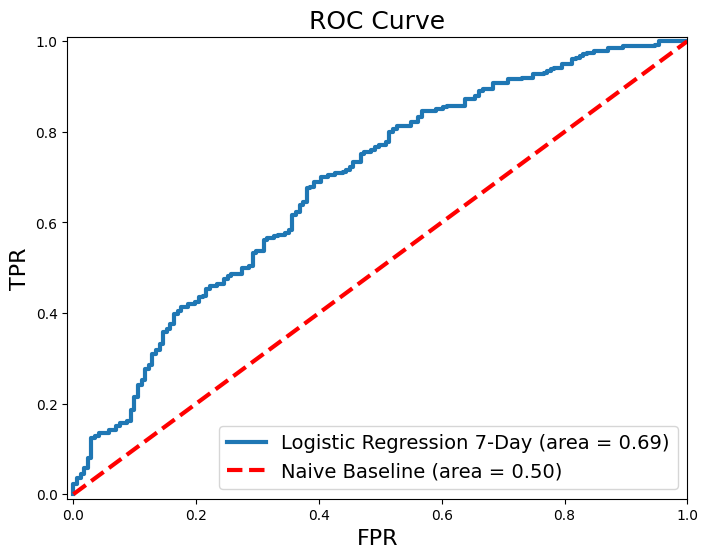

In [39]:
fpr_7, tpr_7, _ = roc_curve(y_test_7, y_prob_7) # FPR, TPR, thresholds
roc_auc_7 = auc(fpr_7, tpr_7)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_7, tpr_7, lw=3, label='Logistic Regression 7-Day (area = {:0.2f})'.format(roc_auc_7))
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

------------------------------------------------------
**30-Day, feature with "Open", "High", "Low", "vix_Open","vix_High", "vix_Low", "nasdaq_Low", "RSI"**

In [40]:
data_30 = pd.read_csv("dataset_30days.csv")
data_30.head(2)

,Date,Open,High,Low,Close,Volume,Adjusted Close,vix_Open,vix_High,vix_Low,...,RSI,MACD,MACD Signal,MACD Hist,%K,%D,ROC,OBV,Williams %R,Price_30_days_Status
0,2010-02-22,201.457932,203.448268,198.741278,201.054768,2.327368e+07,6.110755,22.761577,23.686155,21.690895,...,11.666957,-3.130348,0.521689,-3.652037,28.769568,25.995062,-0.612386,-4.783947e+08,-68.383269,1
1,2010-02-23,201.353781,203.296944,198.524731,200.769320,2.307833e+07,6.102079,22.592157,23.561414,21.574388,...,10.986228,-2.988558,0.530783,-3.519341,30.459477,28.380636,-0.433557,-5.014730e+08,-69.219620,1


In [41]:
# X_train, X_test, y_train, y_test
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(data_30, data_30[["Price_30_days_Status"]], test_size=0.2, random_state=42)

X_test_30 = X_test_30.drop(columns='Price_30_days_Status')

y_prob_30 = logreg.predict(X_test_30)
y_pred_30 = pd.Series([1 if x >= 0.5 else 0 for x in y_prob_30], index=y_prob_30.index)

cm_30 = confusion_matrix(y_test_30, y_pred_30)
TN_30, FP_30, FN_30, TP_30 = cm_30.ravel()
acc_30 = (TN_30 + TP_30) / sum(cm_30.ravel())
acc_30

0.6957494407158836

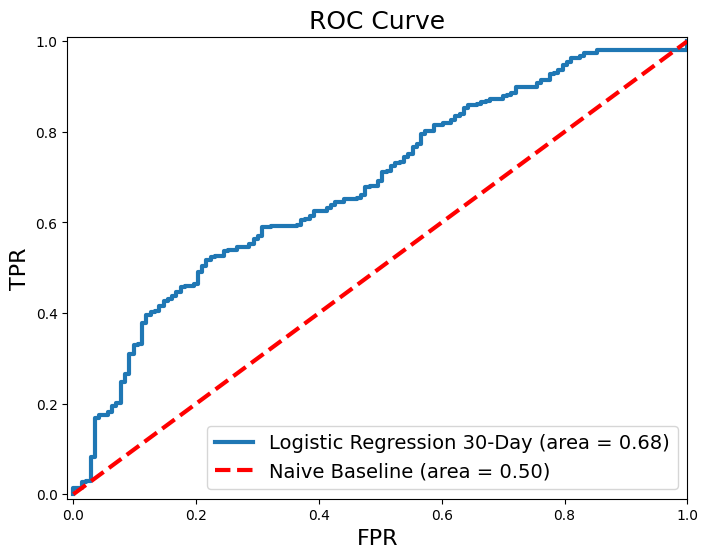

In [42]:
fpr_30, tpr_30, _ = roc_curve(y_test_30, y_prob_30) # FPR, TPR, thresholds
roc_auc_30 = auc(fpr_30, tpr_30)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_30, tpr_30, lw=3, label='Logistic Regression 30-Day (area = {:0.2f})'.format(roc_auc_30))
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

------------------------------------------------------
**60-Day, feature with "Open", "High", "Low", "vix_Open","vix_High", "vix_Low", "nasdaq_Low", "RSI"**

In [43]:
data_60 = pd.read_csv("dataset_60days.csv")
data_60.head(2)

,Date,Open,High,Low,Close,Volume,Adjusted Close,vix_Open,vix_High,vix_Low,...,RSI,MACD,MACD Signal,MACD Hist,%K,%D,ROC,OBV,Williams %R,Price_60_days_Status
0,2010-02-22,202.645843,204.651736,199.699169,202.069393,2.437057e+07,6.141593,22.441123,23.412303,21.398762,...,5.475305,-2.807528,0.376391,-3.183919,26.264933,24.561877,-0.805526,-5.099742e+08,-71.998405,1
1,2010-02-23,202.519870,204.493583,199.509238,201.830840,2.418814e+07,6.134343,22.343465,23.342204,21.335021,...,5.157806,-2.698690,0.388184,-3.086873,27.167217,25.978187,-0.651424,-5.341623e+08,-72.944631,1


In [44]:
# X_train, X_test, y_train, y_test
X_train_60, X_test_60, y_train_60, y_test_60 = train_test_split(data_60, data_60[["Price_60_days_Status"]], test_size=0.2, random_state=42)

X_test_60 = X_test_60.drop(columns='Price_60_days_Status')

y_prob_60 = logreg.predict(X_test_60)
y_pred_60 = pd.Series([1 if x >= 0.5 else 0 for x in y_prob_30], index=y_prob_60.index)

cm_60 = confusion_matrix(y_test_60, y_pred_60)
TN_60, FP_60, FN_60, TP_60 = cm_60.ravel()
acc_60 = (TN_60 + TP_60) / sum(cm_60.ravel())
acc_60

0.7897091722595079

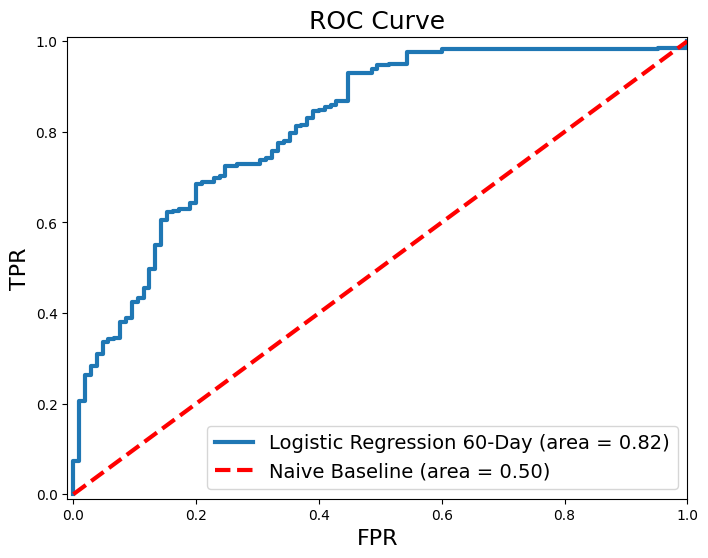

In [45]:
fpr_60, tpr_60, _ = roc_curve(y_test_60, y_prob_60) # FPR, TPR, thresholds
roc_auc_60 = auc(fpr_60, tpr_60)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_60, tpr_60, lw=3, label='Logistic Regression 60-Day (area = {:0.2f})'.format(roc_auc_60))
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

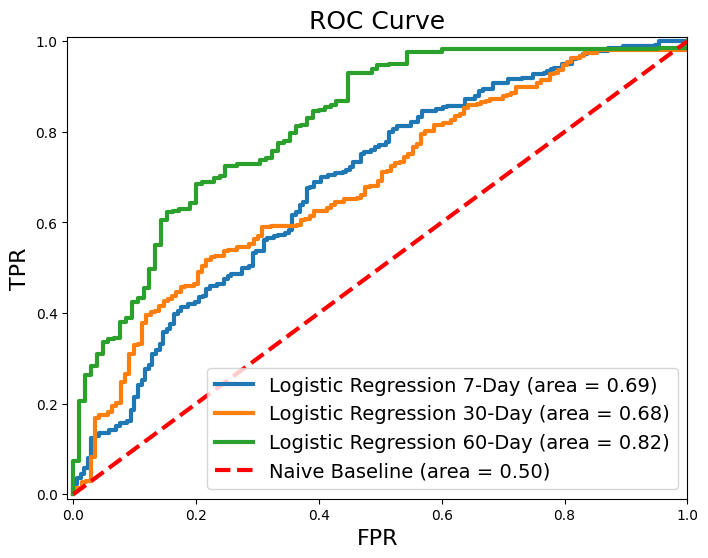

In [46]:
plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_7, tpr_7, lw=3, label='Logistic Regression 7-Day (area = {:0.2f})'.format(roc_auc_7))
plt.plot(fpr_30, tpr_30, lw=3, label='Logistic Regression 30-Day (area = {:0.2f})'.format(roc_auc_30))
plt.plot(fpr_60, tpr_60, lw=3, label='Logistic Regression 60-Day (area = {:0.2f})'.format(roc_auc_60))
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()

------------------------------------------------------
**7-Day, 30-Day, 60-Day, use the same model, predict 2019 data.**


In [47]:
data_7_19 = pd.read_csv("2019_7days_.csv")
data_7_19.head(2)

,Date,Open,High,Low,Close,Volume,Adjusted Close,vix_Open,vix_High,vix_Low,...,MACD Signal,MACD Hist,%K,%D,ROC,OBV,Williams %R,Price_7_days,Close_Price_Change,Price_7_days_Status
0,2019-02-19,170.140578,171.408053,169.237938,170.371561,2.336423e+07,41.197276,16.013184,16.620383,15.082503,...,-0.089893,5.494232,93.493794,93.251220,3.935019,5.628781e+08,-6.310114,173.193424,2.821863,1
1,2019-02-20,170.402945,171.886060,169.675972,170.786188,2.405179e+07,41.303413,15.739873,16.262767,14.809362,...,-0.175388,5.450385,93.145646,93.224109,2.581771,5.869299e+08,-7.582626,173.637571,2.851382,1


In [48]:
# X_train, X_test, y_train, y_test
y_test_7_19 = data_7_19[["Price_7_days_Status"]]
X_test_7_19 = data_7_19.drop(columns='Price_7_days_Status')

y_prob_7_19 = logreg.predict(X_test_7_19)
y_pred_7_19 = pd.Series([1 if x >= 0.5 else 0 for x in y_prob_7_19], index=y_prob_7_19.index)

cm_7_19 = confusion_matrix(y_test_7_19, y_pred_7_19)
TN_7_19, FP_7_19, FN_7_19, TP_7_19 = cm_7_19.ravel()
acc_7_19 = (TN_7_19 + TP_7_19) / sum(cm_7_19.ravel())
acc_7_19

0.6537735849056604

In [49]:
fpr_7_19, tpr_7_19, _ = roc_curve(y_test_7_19, y_prob_7_19) # FPR, TPR, thresholds
roc_auc_7_19 = auc(fpr_7_19, tpr_7_19)


In [50]:
data_30_19 = pd.read_csv("2019_30days_.csv")

y_test_30_19 = data_30_19[["Price_30_days_Status"]]
X_test_30_19 = data_30_19.drop(columns='Price_30_days_Status')

y_prob_30_19 = logreg.predict(X_test_30_19)
y_pred_30_19 = pd.Series([1 if x >= 0.5 else 0 for x in y_prob_30_19], index=y_prob_30_19.index)

cm_30_19 = confusion_matrix(y_test_30_19, y_pred_30_19)
TN_30_19, FP_30_19, FN_30_19, TP_30_19 = cm_30_19.ravel()
acc_30_19 = (TN_30_19 + TP_30_19) / sum(cm_30_19.ravel())
acc_30_19

0.6830188679245283

In [51]:
fpr_30_19, tpr_30_19, _ = roc_curve(y_test_30_19, y_prob_30_19) # FPR, TPR, thresholds
roc_auc_30_19 = auc(fpr_30_19, tpr_30_19)


In [53]:
data_60_19 = pd.read_csv("2019_60days_.csv")

y_test_60_19 = data_60_19[["Price_60_days_Status"]]
X_test_60_19 = data_60_19.drop(columns='Price_60_days_Status')

y_prob_60_19 = logreg.predict(X_test_60_19)
y_pred_60_19 = pd.Series([1 if x >= 0.5 else 0 for x in y_prob_60_19], index=y_prob_60_19.index)

cm_60_19 = confusion_matrix(y_test_60_19, y_pred_60_19)
TN_60_19, FP_60_19, FN_60_19, TP_60_19 = cm_60_19.ravel()
acc_60_19 = (TN_60_19 + TP_60_19) / sum(cm_60_19.ravel())
acc_60_19

0.7235849056603774

In [54]:
fpr_60_19, tpr_60_19, _ = roc_curve(y_test_60_19, y_prob_60_19) # FPR, TPR, thresholds
roc_auc_60_19 = auc(fpr_60_19, tpr_60_19)

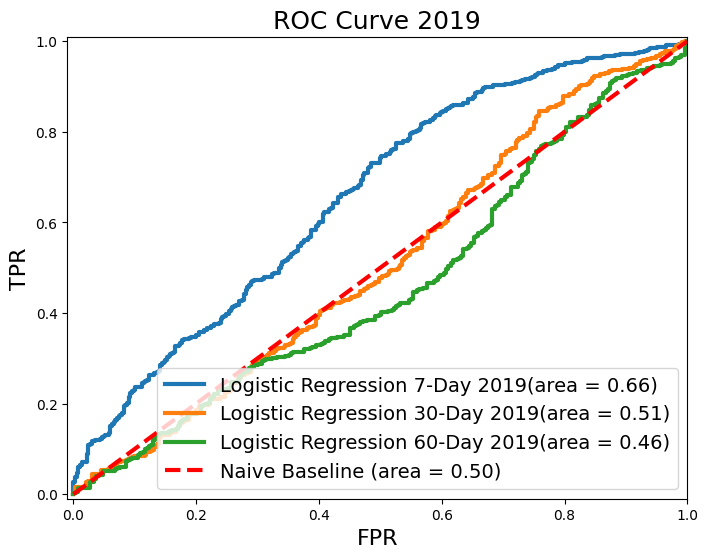

In [55]:
plt.figure(figsize=(8, 6))
plt.title('ROC Curve 2019', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot(fpr_7_19, tpr_7_19, lw=3, label='Logistic Regression 7-Day 2019(area = {:0.2f})'.format(roc_auc_7_19))
plt.plot(fpr_30_19, tpr_30_19, lw=3, label='Logistic Regression 30-Day 2019(area = {:0.2f})'.format(roc_auc_30_19))
plt.plot(fpr_60_19, tpr_60_19, lw=3, label='Logistic Regression 60-Day 2019(area = {:0.2f})'.format(roc_auc_60_19))
plt.plot([0, 1], [0, 1], color='red', lw=3, linestyle='--', label='Naive Baseline (area = 0.50)')
plt.legend(loc='lower right', fontsize=14)
plt.show()